# Set Up

### Supplementary Functions

In [1092]:
# Format the set of requiremnets into a digestible string of text for the evaluator
def get_requirement_set_string(req_json):
    requirement_set = ""
    for uc in req_json["use-cases"]:
        requirement_set += f"{uc['description']} "
        requirement_set += f"{uc['success-end-condition']} "

    for fr in req_json["functional-requirements"]:
        requirement_set += f"{fr['description']} "

    for nfr in req_json["non-functional-requirements"]:
        requirement_set += f"{nfr['description']} "
    
    return requirement_set

In [1093]:
# Format the set of requiremnets into a digestible list of text
def get_requirement_set_list(req_json):
    requirement_set = []
    use_cases = ""
    for uc in req_json["use-cases"]:
        use_cases += f"\n{uc['description']}"
        use_cases += f"\n{uc['success-end-condition']}"
    requirement_set.append(use_cases)


    ifr = 1
    frs = ""
    for fr in req_json["functional-requirements"]:
        frs += f"\n{ifr}. {fr['description']}"
        ifr += 1
    requirement_set.append(frs)

    infr = 1
    nfrs = ""
    for nfr in req_json["non-functional-requirements"]:
        nfrs += f"\n{infr}. {nfr['description']}"
        infr += 1
    requirement_set.append(nfrs)
    
    return requirement_set

In [1094]:
# Quietly ignore some unnecessary warnings
from transformers import logging
logging.set_verbosity_error()

### Constants

In [1095]:
# Select the user story for evaluation
CURRENT_STORY = 3

In [1096]:
MODEL_NAME = "gpt-4o"

In [1097]:
# File references
OUTPUT_FILES = [
    "outputs/final/1-map-traffic-data.json",
    "outputs/final/2-inspection-notifications.json",
    "outputs/final/3-color-coded-results.json",
    "outputs/final/4-powerpoint-report.json"
]
ITER_FILES = [
    "outputs/final/1-map-traffic-data-iterations.json",
    "outputs/final/2-inspection-notifications-iterations.json",
    "outputs/final/3-color-coded-results-iterations.json",
    "outputs/final/4-powerpoint-report-iterations.json"
]
REF_FILE_PATH = "inputs/user_story_set.json"

In [1098]:
import json
# Get the right file path
PRED_FILE_PATH = OUTPUT_FILES[CURRENT_STORY]

# Get the user story
USER_STORY = json.load(open(REF_FILE_PATH))["user-stories"][CURRENT_STORY]["user-story"]

# Get the generated requirement set and into text-only (for analysis)
PRED_JSON = json.load(open(PRED_FILE_PATH))
PRED_TEXT = get_requirement_set_string(PRED_JSON)
PRED_LIST = get_requirement_set_list(PRED_JSON)

# Get the various iterations of StoryInterpreter
ITER_JSON = json.load(open(ITER_FILES[CURRENT_STORY]))

# Do the same for the reference text
REF_JSON = json.load(open(REF_FILE_PATH))["user-stories"][CURRENT_STORY]["reference-output"]
REF_TEXT = get_requirement_set_string(REF_JSON)
REF_LIST = get_requirement_set_list(REF_JSON)


In [1099]:
ROUGE_METRICS = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
ROUGE_LABELS = ['Recall', 'Precision', 'F1']
BERT_LABELS = ["BERT Recall", "BERT Precision", "BERT F1"]

In [1100]:
# Feedback
print(f"Currently evaluating responses generated for:\n{USER_STORY}")

Currently evaluating responses generated for:
As an advanced user, I want to export bridge analysis results to a PowerPoint presentation, so that I can present risk analysis and recommendations to management personnel in a digestible format.


### ROUGE Scorer

In [1101]:
# function to calculate the Rouge score
from rouge import Rouge

def get_rouge_scores(text1, text2):
    rouge = Rouge()
    return rouge.get_scores(text1, text2)

### BERTSCorer

In [1102]:
# function to calculate the BERTScore
from bert_score import BERTScorer

def get_bert_scores(text1, text2):
    bert = BERTScorer(lang="en")
    prec, recall, f1 = bert.score([text1], [text2])
    return prec.tolist()[0], recall.tolist()[0], f1.tolist()[0]

# Target Comparison

### Use BERTScore and ROUGE scores to compare the generated final output against the reference text.

In [1103]:
print(PRED_TEXT)

The advanced user exports bridge analysis results to a PowerPoint presentation to present risk analysis and recommendations in a digestible format for management personnel. The bridge analysis results are converted into a PowerPoint presentation and made available for download/export from the system. The system shall allow users to export bridge analysis results into a .pptx file format that is compatible with Microsoft PowerPoint. The system shall enable the user to select specific bridge analysis results and their corresponding visualizations for inclusion in a PowerPoint presentation. The system shall format the exported PowerPoint presentation to include bridge analysis summaries, visualizations, and recommendations, each labeled with a title and organized into separate sections. When the user initiates the final export process, the system shall display a preview of the PowerPoint presentation, including all slides and content. The system shall allow users to customize slide titles

In [1104]:
print(REF_TEXT)

After performing a bridge analysis for a structure, the user clicks the button to export the bridge analysis report to PowerPoint format. The user then customizes the layout and format of the PowerPoint report. The PowerPoint report is generated with bridge visuals, inspection results, structure work items, and condition ratings in a visually digestible format for executive review. The system shall allow users to export analysis results into a PowerPoint report format. When the user selects the option to export bridge analysis results to PowerPoint format, the system shall display a pop-up window to choose from a pre-formatted choice of the following themes: 'dark', 'light', and 'sepia'. When the user selects the option to export bridge analysis results to PowerPoint format, the system shall output the following information into the slides: structure identification number, last inspection date, inspection results, structure condition ratings, outstanding work items, impact of work item

In [1105]:
# Compile into dataframe for easier copy/paste
target_eval_scores = {}
rouge_headers = []
for metric in ROUGE_METRICS:
    for label in ROUGE_LABELS:
        rouge_headers.append(f"{metric} {label}")
bert_headers = [f"BERT {i}" for i in BERT_LABELS]

In [1106]:
# Compute the ROUGE score
rouge_ref_score = get_rouge_scores(PRED_TEXT, REF_TEXT)
for metric in ROUGE_METRICS:
    for label in ROUGE_LABELS:
        rouge_header = f"{metric.upper()} {label}"
        rouge_score = round(rouge_ref_score[0][metric.lower()][label[0].lower()]*100, 2)
        target_eval_scores[rouge_header] = rouge_score
        print(f"{rouge_header}: {rouge_score}")

ROUGE-1 Recall: 43.3
ROUGE-1 Precision: 20.29
ROUGE-1 F1: 27.63
ROUGE-2 Recall: 23.35
ROUGE-2 Precision: 10.96
ROUGE-2 F1: 14.91
ROUGE-L Recall: 41.24
ROUGE-L Precision: 19.32
ROUGE-L F1: 26.32


In [1107]:
# Compute the BERTScore
bert_ref_prec, bert_ref_recall, bert_ref_f1 = get_bert_scores(PRED_TEXT, REF_TEXT)
target_eval_scores["BERT Precision"] = round(bert_ref_prec*100, 2)
target_eval_scores["BERT Recall"] = round(bert_ref_recall*100, 2)
target_eval_scores["BERT F1"] = round(bert_ref_f1*100, 2)
print(f"BERT Precision: {round(bert_ref_prec*100, 2)}")
print(f"BERT Recall: {round(bert_ref_recall*100, 2)}")
print(f"BERT F1: {round(bert_ref_f1*100,2)}")

BERT Precision: 84.6
BERT Recall: 87.13
BERT F1: 85.85


In [1108]:
import pandas as pd
target_eval_scores_df = pd.DataFrame(target_eval_scores, index=[0])

display(target_eval_scores_df)

,ROUGE-1 Recall,ROUGE-1 Precision,ROUGE-1 F1,ROUGE-2 Recall,ROUGE-2 Precision,ROUGE-2 F1,ROUGE-L Recall,ROUGE-L Precision,ROUGE-L F1,BERT Precision,BERT Recall,BERT F1
0,43.3,20.29,27.63,23.35,10.96,14.91,41.24,19.32,26.32,84.6,87.13,85.85


# Output Consistency

Use BERTScorer and ROUGE to compare against several iterations of the same prompt

In [1109]:
# Load the iterations and use the first one as reference
REF_ITER = ITER_JSON[0]
PRED_ITER = ITER_JSON[1:5]
req_iters_label = [f"US{CURRENT_STORY+1}-{i+2}"for i in range(4)]
req_iters_dict = dict(zip(req_iters_label, PRED_ITER))


In [1110]:
import pandas as pd

story_header = "User Story Iteration"
rouge_headers = []
for metric in ROUGE_METRICS:
    for label in ROUGE_LABELS:
        rouge_headers.append(f"{metric} {label}")
bert_headers = [f"BERT {i}" for i in BERT_LABELS]
iter_eval_scores = pd.DataFrame(columns=[story_header] + rouge_headers + bert_headers)

for iter_label, iter_req in req_iters_dict.items():
    row = {story_header: iter_label}
    
    # Calculate the ROUGE-N scores
    for metric in ROUGE_METRICS:    
        for label in ROUGE_LABELS:
            # Calculate the ROUGE scores for the requirements using reference
            eval_rouge = get_rouge_scores(iter_req, REF_ITER)
            iter_rouge_score = eval_rouge[0][metric.lower()][label[0].lower()]
            row[f"{metric} {label}"] = iter_rouge_score*100
    
    # Calculate the BERTScore
    iter_bert_score = list(get_bert_scores(iter_req, REF_ITER))
    iter_bert_dict = dict(zip(bert_headers, [i * 100 for i in iter_bert_score]))
    row.update(iter_bert_dict)

    # Add the evaluation to the current iteration's set of scores
    iter_eval_scores.loc[len(iter_eval_scores.index)] = row

iter_eval_scores = iter_eval_scores.round(2).set_index(story_header)
display(iter_eval_scores)

,ROUGE-1 Recall,ROUGE-1 Precision,ROUGE-1 F1,ROUGE-2 Recall,ROUGE-2 Precision,ROUGE-2 F1,ROUGE-L Recall,ROUGE-L Precision,ROUGE-L F1,BERT BERT Recall,BERT BERT Precision,BERT BERT F1
User Story Iteration,,,,,,,,,,,,
US4-2,45.12,60.66,51.75,27.01,38.14,31.62,43.29,58.20,49.65,93.42,91.39,92.39
US4-3,42.07,63.89,50.74,27.37,41.21,32.89,37.20,56.48,44.85,93.75,91.30,92.51
US4-4,39.02,61.54,47.76,23.36,37.43,28.76,37.80,59.62,46.27,92.96,90.21,91.56
US4-5,51.22,56.38,53.67,31.02,33.73,32.32,48.17,53.02,50.48,92.49,91.28,91.88


In [1111]:
eval_scores_out = iter_eval_scores.style.highlight_max(color="darkgreen", axis=0).highlight_min(color="darkred", axis=0)

eval_scores_out

,ROUGE-1 Recall,ROUGE-1 Precision,ROUGE-1 F1,ROUGE-2 Recall,ROUGE-2 Precision,ROUGE-2 F1,ROUGE-L Recall,ROUGE-L Precision,ROUGE-L F1,BERT BERT Recall,BERT BERT Precision,BERT BERT F1
User Story Iteration,,,,,,,,,,,,
US4-2,45.120000,60.660000,51.750000,27.010000,38.140000,31.620000,43.290000,58.200000,49.650000,93.420000,91.390000,92.390000
US4-3,42.070000,63.890000,50.740000,27.370000,41.210000,32.890000,37.200000,56.480000,44.850000,93.750000,91.300000,92.510000
US4-4,39.020000,61.540000,47.760000,23.360000,37.430000,28.760000,37.800000,59.620000,46.270000,92.960000,90.210000,91.560000
US4-5,51.220000,56.380000,53.670000,31.020000,33.730000,32.320000,48.170000,53.020000,50.480000,92.490000,91.280000,91.880000


# Token and Artifact Counter

### Set Up

In [1112]:
import tiktoken

def count_tokens(text):
    encoding = tiktoken.encoding_for_model(MODEL_NAME)
    num_tokens = len(encoding.encode(text))
    return num_tokens

In [1113]:
def count_frs(req_json):
    return len(req_json["functional-requirements"])

In [1114]:
def count_nfrs(req_json):
    return len(req_json["non-functional-requirements"])

### Count Tokens

In [1115]:
num_ref_tokens = count_tokens(REF_TEXT)
num_pred_tokens = count_tokens(PRED_TEXT)

print(f"Number of Reference Tokens: {num_ref_tokens}")
print(f"Number of Prediction Tokens: {num_pred_tokens}")

Number of Reference Tokens: 353
Number of Prediction Tokens: 536


### Count Artifacts

In [1116]:
num_ref_frs = count_frs(REF_JSON)
num_pred_frs = count_frs(PRED_JSON)

print(f"Number of Functional Requirements in the Reference: {num_ref_frs}")
print(f"Number of Functional Requirements in the Prediction: {num_pred_frs}")


Number of Functional Requirements in the Reference: 4
Number of Functional Requirements in the Prediction: 8


In [1117]:
num_ref_nfrs = count_nfrs(REF_JSON)
num_pred_nfrs = count_nfrs(PRED_JSON)

print(f"Number of Non-Functional Requirements in the Reference: {num_ref_nfrs}")
print(f"Number of Non-Functional Requirements in the Prediction: {num_pred_nfrs}")

Number of Non-Functional Requirements in the Reference: 4
Number of Non-Functional Requirements in the Prediction: 9


# Topic Modeling

## Word Cloud

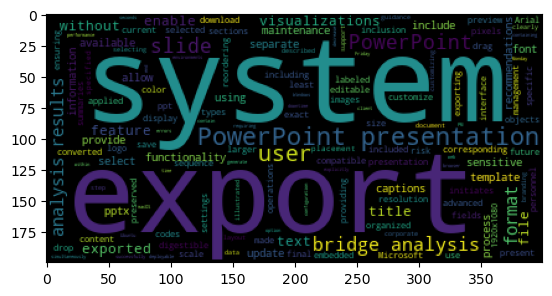

In [1118]:
import json
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Plot in a word cloud
wc = WordCloud().generate(PRED_TEXT)
plt.imshow(wc)

## LDA Topic Model
From [IBM Tutorial](https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/)


In [1119]:
# download necessary libraries and packages for our topic modeling algorithm
# %pip install nltk -U
# %pip install spacy -U
# %pip install gensim
# %pip install pyldavis
# %pip install gutenbergpy

import os
import nltk
import re
import string
import gensim
import numpy as np

# for cleaning prefatory matter from Project Gutenberg texts
from gutenbergpy import textget

# for tokenization
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('wordnet')

# for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')

# for lemmatization and POS tagging
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# for LDA
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# for LDA evaluation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kailaniredding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kailaniredding/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kailaniredding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kailaniredding/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [1120]:
# load WordNet POS tags for lemmatization
def wordnet_pos_tags(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# preprocessing function
def txt_preprocess_pipeline(text):
    # read file contents as text string
    # working_txt = text.read()
    working_txt = text
    # strip Project Gutenberg headers
    main_txt = textget.strip_headers(working_txt.encode('utf-8')).decode('utf-8')
    # strip Project Gutenberg footer
    main_txt = re.sub(r'end of the project gutenberg', '', main_txt, flags=re.IGNORECASE)
    # standardize text to lowercase
    standard_txt = main_txt.lower()
    # remove multiple white spaces and line breaks
    clean_txt = re.sub(r'\n', ' ', standard_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = clean_txt.strip()
    # tokenize text
    tokens = word_tokenize(clean_txt)
    # remove non-alphabetic tokens
    filtered_tokens_alpha = [word for word in tokens if word.isalpha() and not re.match(r'^[ivxlcdm]+$', word)]
    # load NLTK stopword list and add original stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['shall', 'system', 'when', 'while', 'if'])
    # remove stopwords
    filtered_tokens_final = [w for w in filtered_tokens_alpha if not w in stop_words]
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    # conduct POS tagging
    pos_tags = nltk.pos_tag(filtered_tokens_final)
    # lemmatize word-tokens via assigned POS tags
    lemma_tokens = [lemmatizer.lemmatize(token, wordnet_pos_tags(pos_tag)) for token, pos_tag in pos_tags]
    return lemma_tokens

# file iteration function
def iterate_txt(input_reqs):
    texts = []
    for text in input_reqs:
        txt_tokens = txt_preprocess_pipeline(text)
        texts.append(txt_tokens)
    return texts

In [1121]:
# define working directory
work_dir = "outputs/evaluation"
# specify path to text corpus inside working directory
file_dir = f'{work_dir}'

# iterate through each text
texts = iterate_txt([PRED_TEXT])

# print first processed text
print(texts[:1])

[['advanced', 'user', 'export', 'bridge', 'analysis', 'result', 'powerpoint', 'presentation', 'present', 'risk', 'analysis', 'recommendation', 'digestible', 'format', 'management', 'personnel', 'bridge', 'analysis', 'result', 'convert', 'powerpoint', 'presentation', 'make', 'available', 'allow', 'user', 'export', 'bridge', 'analysis', 'result', 'file', 'format', 'compatible', 'microsoft', 'powerpoint', 'enable', 'user', 'select', 'specific', 'bridge', 'analysis', 'result', 'correspond', 'visualization', 'inclusion', 'powerpoint', 'presentation', 'format', 'export', 'powerpoint', 'presentation', 'include', 'bridge', 'analysis', 'summary', 'visualization', 'recommendation', 'label', 'title', 'organize', 'separate', 'section', 'user', 'initiate', 'final', 'export', 'process', 'display', 'preview', 'powerpoint', 'presentation', 'include', 'slide', 'content', 'allow', 'user', 'customize', 'slide', 'title', 'slide', 'caption', 'sequence', 'slide', 'powerpoint', 'presentation', 'provide', 'ed

In [1122]:
# load dictionary
dictionary = corpora.Dictionary(texts)
# dictionary.filter_extremes(no_below = 1)

# generate corpus as BoW
corpus = [dictionary.doc2bow(text) for text in texts]

# train LDA model
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    random_state=4583, 
    chunksize=20, 
    num_topics=6, 
    passes=200, 
    iterations=400)

# print LDA topics
for topic in lda_model.print_topics(num_topics=6, num_words=10):
    print(topic)

(0, '0.008*"personnel" + 0.008*"placement" + 0.008*"option" + 0.008*"organize" + 0.008*"performance" + 0.008*"object" + 0.008*"pixels" + 0.008*"preserve" + 0.008*"present" + 0.008*"monday"')
(1, '0.008*"personnel" + 0.008*"placement" + 0.008*"option" + 0.008*"organize" + 0.008*"performance" + 0.008*"object" + 0.008*"pixels" + 0.008*"preserve" + 0.008*"present" + 0.008*"monday"')
(2, '0.070*"powerpoint" + 0.062*"export" + 0.047*"presentation" + 0.035*"user" + 0.027*"analysis" + 0.027*"slide" + 0.024*"bridge" + 0.020*"format" + 0.020*"result" + 0.016*"include"')
(3, '0.008*"personnel" + 0.008*"placement" + 0.008*"option" + 0.008*"organize" + 0.008*"performance" + 0.008*"object" + 0.008*"pixels" + 0.008*"preserve" + 0.008*"present" + 0.008*"monday"')
(4, '0.008*"personnel" + 0.008*"placement" + 0.008*"option" + 0.008*"organize" + 0.008*"performance" + 0.008*"object" + 0.008*"pixels" + 0.008*"preserve" + 0.008*"present" + 0.008*"monday"')
(5, '0.008*"personnel" + 0.008*"placement" + 0.008*

In [1123]:
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(coherence_score)

0.2953842205818317


In [1124]:
dickens_visual = gensimvisualize.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(dickens_visual)

/Users/kailaniredding/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kailaniredding/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/kailaniredding/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
